In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import wandb

https://wandb.ai/smaia3/Ques3/reports/Question-3--Vmlldzo1NzU1MzU3?accessToken=3kf0tpwd55tzmmcrm0h8hd4k199c3t64d2256e4kfvs7wspyqxxr7df1ovvjhshj

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

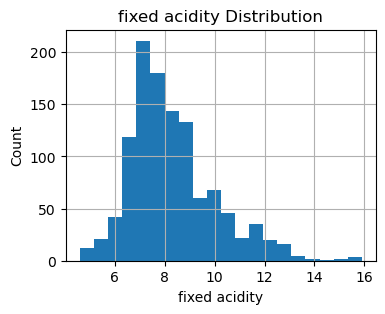

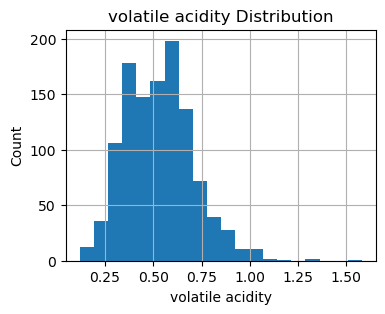

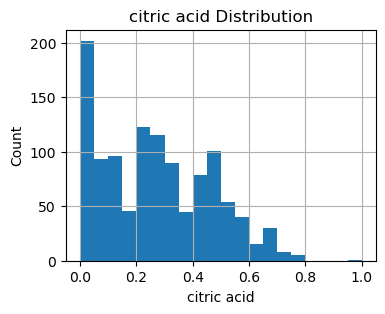

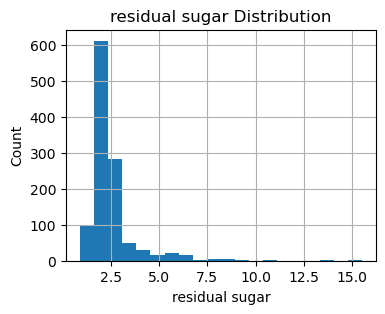

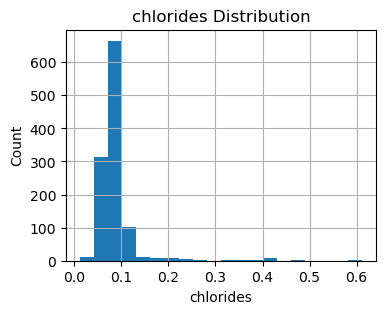

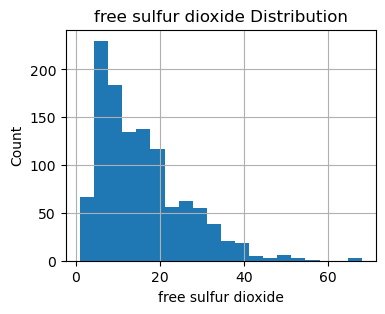

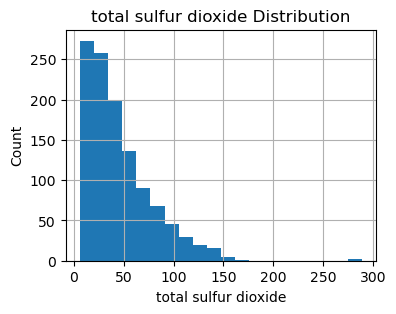

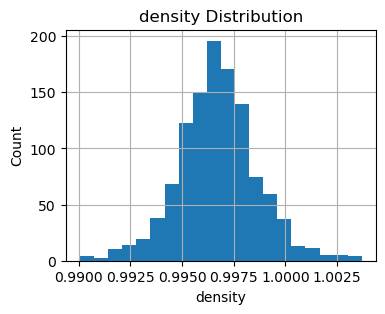

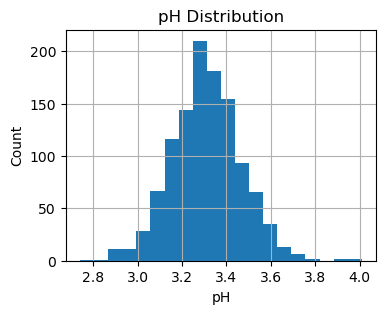

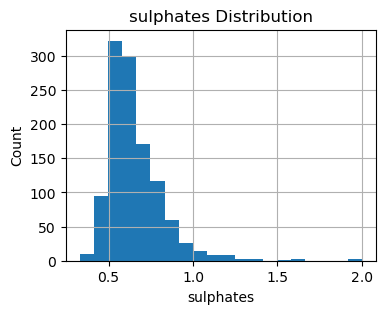

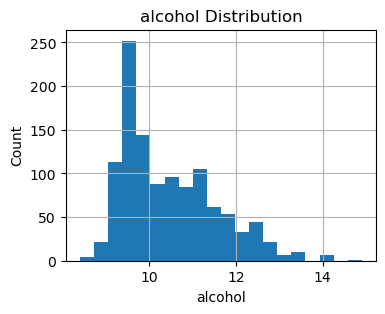

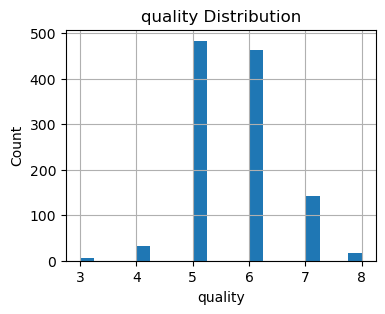

/Users/arygup/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# Load the dataset
data = pd.read_csv('wineQT.csv')

# Handling missing or inconsistent data values Replace missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Describing the dataset
description = data.describe()
print(description)

data = data.drop(columns=['Id'])

# Plot the distribution for all numeric columns
for column in data.columns:
    if column != 'Id':  
        plt.figure(figsize=(4, 3))
        data[column].hist(bins=20)  
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.title(f'{column} Distribution')
        plt.show()

# Partition the dataset, excluding 'quality' column
X = data.drop(['quality'], axis=1)
y = data['quality']

# One-hot encoding for 'quality'
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, temp_data, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.6, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

# Define the columns to normalize
columns_to_normalize = X.columns

# Normalize and standardize the data
scaler = StandardScaler()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_validation[columns_to_normalize] = scaler.transform(X_validation[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

In [5]:
# Define a softmax function to calculate class probabilities
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

# Cross-entropy loss function with handling for divide by zero
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.maximum(epsilon, y_pred)  # Avoid zero or negative values
    return -np.mean(np.log(y_pred[range(len(y_true)), y_true.argmax(axis=1)]))

# Gradient descent optimization
def gradient_descent(X, y, learning_rate, num_epochs, X_validation, y_validation):
    num_classes = y.shape[1]
    num_features = X.shape[1]
    # Initialize weights and bias
    W = np.zeros((num_features, num_classes))
    b = np.zeros((1, num_classes))
    for epoch in range(num_epochs):
        # Forward pass
        z = np.dot(X, W) + b
        y_pred = softmax(z)
        # Calculate loss
        loss = cross_entropy_loss(y, y_pred)
        # Calculate gradients
        grad_z = y_pred
        grad_z[range(len(y)), y.argmax(axis=1)] -= 1
        grad_z /= len(y)
        grad_W = np.dot(X.T, grad_z)
        grad_b = np.sum(grad_z, axis=0, keepdims=True)
        # Update weights and bias
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        # Calculate accuracy on the training set
        # y_pred_labels = np.argmax(y_pred, axis=1)
        # accuracy = np.mean(y_pred_labels == y.argmax(axis=1) - 1)
        # Calculate metrics on the validation set
        val_X = X_validation
        val_y = y_validation
        val_z = np.dot(val_X, W) + b
        val_y_pred = softmax(val_z)
        val_y_pred_labels = np.argmax(val_y_pred, axis=1)
        val_accuracy = np.mean(val_y_pred_labels == val_y.argmax(axis=1))
        # val_report = classification_report(val_y.argmax(axis=1), val_y_pred_labels, zero_division=0)
        wandb.log({"epoch": epoch, "acc": val_accuracy})

        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        # print(f"Validation Accuracy: {val_accuracy:.4f}")
        # print(f"Validation Classification Report:\n{val_report}\n")
        # print(f"Validation y:\n{y.argmax(axis=1)}\n")
        # print(f"Validation y_pred:\n{y_pred_labels}\n")
        return W, b

In [4]:
# Set hyperparameters
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
num_epochs = 10000

# Train the model
for learning_rate in learning_rates:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Q1",
        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "architecture": "Logistic Regression",
        "dataset": "wineQT",
        },
        name=f"LR_{learning_rate}" 
    )
    wandb.config.learning_rate = learning_rate
    gradient_descent(X_train, y_train, learning_rate, num_epochs, X_validation, y_validation)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aryan-g (smaia3). Use `wandb login --relogin` to force relogin


acc,▂▁▁▂▂▂▂▂▃▂▂▂▂▃▃▃▃▄▆▆▆▆▇▇▆▆▇███▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
acc,0.60933
epoch,9999


acc,▁▁▅▆▆▆▇▇▇▇▇▇▇▇██▇▇████████████████████▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
acc,0.62391
epoch,9999


acc,▁▄▇█▅▇▇▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
acc,0.61808
epoch,9999


acc,██▄▂▂▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
acc,0.61224
epoch,9999


In [16]:
# clearly max at 
learning_rate = 0.01
num_epochs = 7000
W, b = gradient_descent(X_train, y_train, learning_rate, num_epochs, X_validation, y_validation)



z = np.dot(X_train, W) + b
y_pred = softmax(z)
y_pred_labels = np.argmax(y_pred, axis=1)
print(f"Loss: {cross_entropy_loss(y_train, y_pred):.4f}, Accuracy: {np.mean(y_pred_labels == y_train.argmax(axis=1) - 1):.4f}")

print()

val_z = np.dot(X_test, W) + b
val_y_pred = softmax(val_z)
val_y_pred_labels = np.argmax(val_y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), val_y_pred_labels, zero_division=0))

Loss: 1.7879, Accuracy: 0.2867

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        11
           2       0.55      0.77      0.64       142
           3       0.52      0.51      0.51       146
           4       0.50      0.05      0.09        39
           5       0.00      0.00      0.00         4

    accuracy                           0.54       343
   macro avg       0.26      0.22      0.21       343
weighted avg       0.51      0.54      0.50       343

